# <span style="color: yellow;">KaggleX Skill Assessment Challenge</span>
<span style="color: silver;">Thamsanqa Lucas Vetezo</span>

* <span style="color: gold;">Predict the price of a used vehicle, using the data sets provided.</span>



* <span style="color: gold;">Import important libraries </span>

In [217]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from xgboost import XGBRegressor

from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


* <span style="color: gold;">Load the data</span>

In [2]:
train_path = '/Users/charityvetezo/Desktop/Data Sciences/Kaggle/Skills Assessment/train.csv'
test_path = '/Users/charityvetezo/Desktop/Data Sciences/Kaggle/Skills Assessment/test.csv'

# <span style="color: yellow;">1. Data checks </span> 

 <span style="color: silver;">In this section, the focus is more on getting a read on the data sets provided.  </span>

##### <span style="color: green;">- Shape and missing values</span>

In [3]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Check the shape of the dataset 
df_train.shape, df_test.shape

((54273, 13), (36183, 12))

* <span style="color: gold;">The test data provided is missing one column, which is essential for testing the accuracy and performance of the model. Therefore it will be best use the train data set provided as both the train and validate data set. Once happy with the performance of the model, then submit the final prediction using the test data set.</span>

In [223]:
# Calculate missing value counts
train_missing = df_train.isnull().sum()
test_missing = df_test.isnull().sum()

# Combine counts into a DataFrame
missing_value_counts = pd.DataFrame({'Train Set': train_missing, 'Test Set': test_missing})

# Print the DataFrame (table format)
print(missing_value_counts)

              Train Set  Test Set
accident              0       0.0
brand                 0       0.0
clean_title           0       0.0
engine                0       0.0
ext_col               0       0.0
fuel_type             0       0.0
id                    0       0.0
int_col               0       0.0
milage                0       0.0
model                 0       0.0
model_year            0       0.0
price                 0       NaN
transmission          0       0.0


* <span style="color: gold;"> The NaN in the Test Set for the price speaks to the point mentioned above.</span>

##### <span style="color: green;">- Duplicates </span>

In [224]:
df_train.duplicated().sum(), df_test.duplicated().sum()

(0, 0)

##### <span style="color: green;">- Data types </span>

In [226]:
# Check data types
train_dtypes = df_train.dtypes
test_dtypes = df_test.dtypes

# Combine into a DataFrame
data_types = pd.DataFrame({'Train Set': train_dtypes, 'Test Set': test_dtypes})

# Print the DataFrame (table format)
print(data_types)


             Train Set Test Set
accident        object   object
brand           object   object
clean_title     object   object
engine          object   object
ext_col         object   object
fuel_type       object   object
id               int64    int64
int_col         object   object
milage           int64    int64
model           object   object
model_year       int64    int64
price            int64      NaN
transmission    object   object


##### <span style="color: green;">- Uniques values </span>

In [227]:
df_train_uni = df_train.nunique()
df_test_uni = df_test.nunique()

# Combine into a DataFrame
nunique_vals = pd.DataFrame({'Train Set': df_train_uni, 'Test Set': df_test_uni})

# Print the DataFrame (table format)
print(nunique_vals)

              Train Set  Test Set
accident              2       2.0
brand                53      53.0
clean_title           1       1.0
engine             1061    1038.0
ext_col             260     230.0
fuel_type             7       7.0
id                54273   36183.0
int_col             124     111.0
milage             3212    2973.0
model              1827    1791.0
model_year           34      34.0
price              1481       NaN
transmission         46      44.0


##### <span style="color: green;">- Statistics </span>

In [12]:
# Statistics of the data set
df_train.describe()

,id,model_year,milage,price
count,54273.000000,54273.000000,54273.000000,5.427300e+04
mean,27136.000000,2015.091979,72746.175667,3.921844e+04
std,15667.409917,5.588909,50469.490448,7.282634e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,13568.000000,2012.000000,32268.000000,1.550000e+04
50%,27136.000000,2016.000000,66107.000000,2.800000e+04
75%,40704.000000,2019.000000,102000.000000,4.500000e+04
max,54272.000000,2024.000000,405000.000000,2.954083e+06


* <span style="color: gold;">From the above an inference can be made that most vihicles in the data set are fairly new models, with the average model year being 2015. Also it's clear that there are outliers with price value at nearly 3 million dollars. These may cause noise in the model, so filtering them out might be a good choice.  </span>

##### <span style="color: green;">- Various categories present in the dataset  </span>
* <span style="color: gold;">There are various columns with valuable information like the the engine, but are not in the usuable state for modeling. I will clean these up and create meaningful features that will help to get a stronger/better prediction. </span>

In [13]:
# Categorical features
for col in df_train.select_dtypes('object'):
    print(f'Category in {col} is : {df_train[col].unique()}')

Category in brand is : ['Ford' 'BMW' 'Jaguar' 'Pontiac' 'Acura' 'Audi' 'GMC' 'Maserati'
 'Chevrolet' 'Porsche' 'Mercedes-Benz' 'Tesla' 'Lexus' 'Kia' 'Lincoln'
 'Dodge' 'Volkswagen' 'Land' 'Cadillac' 'Mazda' 'RAM' 'Subaru' 'Hyundai'
 'MINI' 'Jeep' 'Honda' 'Hummer' 'Nissan' 'Toyota' 'Volvo' 'Genesis'
 'Mitsubishi' 'Buick' 'INFINITI' 'McLaren' 'Scion' 'Lamborghini' 'Bentley'
 'Suzuki' 'Ferrari' 'Alfa' 'Rolls-Royce' 'Chrysler' 'Aston' 'Rivian'
 'Lotus' 'Saturn' 'Lucid' 'Mercury' 'Maybach' 'FIAT' 'Plymouth' 'Bugatti']
Category in model is : ['F-150 Lariat' '335 i' 'XF Luxury' ... 'Q4 e-tron Sportback Premium'
 'Countryman Cooper' 'S-10 LS']
Category in fuel_type is : ['Gasoline' 'Hybrid' 'E85 Flex Fuel' 'Diesel' '–' 'Plug-In Hybrid'
 'not supported']
Category in engine is : ['375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel'
 '300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel'
 '300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel' ... '3.0L'
 '3.0 Liter GTDI' '120.0HP 2.2L 4 Cylinder Engine Flex 

* <span style="color: gold;"> The horsepower will definitely influence the price of any vehicle, so it will be useful information to use in the model. </span>

# <span style="color: yellow;">2. Cleaning and Feature Engineering </span>

 <span style="color: silver;">In this section, the focus is on cleaning the data sets provided. Extracting new, powerful features which we will later encode and scale to train the model.  </span>

* <span style="color: gold;">Since there's 53 unique car brands in this dataset, it might be best group them into country brands and possibly continants the brands are from. This will help create new powerful features that can be easily scaled and encorporated in the model. </span>

In [229]:
# Top 10 brands by value count
df_train_brands = df_train['brand'].value_counts()[:10]
df_test_brands = df_test['brand'].value_counts()[:10]

# Combine into a DataFrame
top_brands = pd.DataFrame({'Train Set': df_train_brands, 'Test Set': df_test_brands})

# Print the DataFrame (table format)
print(top_brands)


               Train Set  Test Set
brand                             
BMW                 7369      4854
Ford                6706      4382
Mercedes-Benz       5087      3265
Chevrolet           4424      2993
Audi                2922      1919
Porsche             2627      1805
Toyota              2315      1574
Lexus               2257      1530
Jeep                2247      1510
Land                1995      1360


* <span style="color: gold;">This extensive brand distribution in different values will make modeling difficult. Therefore having the brand country of origin will be useful. </span>

In [230]:
# Create dictionary of brands and country of origin
brand_dict = {}
brand_dict['maybach'] = 'Germany'
brand_dict['bmw'] = 'Germany'
brand_dict['audi'] = 'Germany'
brand_dict['mercedes-benz'] = 'Germany'
brand_dict['opel'] = 'Germany'
brand_dict['porsche'] = 'Germany'
brand_dict['smart'] = 'Germany'
brand_dict['volkswagen'] = 'Germany'
brand_dict['ford'] = 'United States'
brand_dict['chevrolet'] = 'United States'
brand_dict['tesla'] = 'United States'
brand_dict['jeep'] = 'United States'
brand_dict['gmc'] = 'United States'
brand_dict['dodge'] = 'United States'
brand_dict['ram'] = 'United States'
brand_dict['infiniti'] = 'United States'
brand_dict['lincoln'] = 'United States'
brand_dict['cadillac'] = 'United States'
brand_dict['plymouth'] = 'United States'
brand_dict['ram'] = 'United States'
brand_dict['chrysler'] = 'United States'
brand_dict['infinity'] = 'United States'
brand_dict['lincoln'] = 'United States'
brand_dict['hummer'] = 'United States'
brand_dict['pontiac'] = 'United States'
brand_dict['saturn'] = 'United States'
brand_dict['rivian'] = 'United States'
brand_dict['mercury'] = 'United States'
brand_dict['buick'] = 'United States'   
brand_dict['lucid'] = 'United States'         
brand_dict['toyota'] = 'Japan'
brand_dict['honda'] = 'Japan'
brand_dict['nissan'] = 'Japan'
brand_dict['mitsubishi'] = 'Japan'
brand_dict['mazda'] = 'Japan'
brand_dict['suzuki'] = 'Japan'
brand_dict['subaru'] = 'Japan'
brand_dict['scion'] = 'Japan'
brand_dict['lexus'] = 'Japan'
brand_dict['acura'] = 'Japan'
brand_dict['land'] = 'United Kingdom'
brand_dict['land rover'] = 'United Kingdom'
brand_dict['jaguar'] = 'United Kingdom'
brand_dict['mini'] = 'United Kingdom'
brand_dict['bentley'] = 'United Kingdom'
brand_dict['rolls-royce'] = 'United Kingdom'
brand_dict['mclaren'] = 'United Kingdom'
brand_dict['lotus'] = 'United Kingdom'
brand_dict['aston'] = 'United Kingdom'
brand_dict['aston martin'] = 'United Kingdom'
brand_dict['hyundai'] = 'South Korea'
brand_dict['kia'] = 'South Korea'
brand_dict['genesis'] = 'South Korea'
brand_dict['maserati'] = 'Italy'
brand_dict['alfa'] = 'Italy'
brand_dict['lamborghini'] = 'Italy'
brand_dict['ferrari'] = 'Italy'
brand_dict['fiat'] = 'Italy'
brand_dict['volvo'] = 'Sweden'
brand_dict['saab'] = 'Sweden'
brand_dict['bugatti'] = 'France'                       

In [231]:
type(brand_dict)

dict

In [258]:
# Create new column with country values from the dictionary created above based on the brand keys mapping
# Train data set
df_train_mod = df_train.copy()
df_train_mod['brand_country'] = df_train_mod['brand'].str.lower().replace(brand_dict)

# Test data set
df_test_mod = df_test.copy()
df_test_mod['brand_country'] = df_test_mod['brand'].str.lower().replace(brand_dict)

In [259]:
df_train_country = df_train_mod['brand_country'].value_counts()
df_test_country = df_test_mod['brand_country'].value_counts()

# Combine into a DataFrame
countries = pd.DataFrame({'Train Set':df_train_country, 'Test Set':df_test_country})

print(countries)

                Train Set  Test Set
brand_country                      
United States       20748     13873
Germany             18636     12221
Japan                8754      5988
United Kingdom       3551      2420
South Korea          1469       956
Italy                 662       413
Sweden                452       311
France                  1         1


* <span style="color: gold;">The leading country brand is the US.  </span>

* <span style="color: gold;"> Let's take it a step further and add the continents. </span> 

In [260]:
europe = ['Germany', 'Italy', 'Sweden', 'United Kingdom', 'France']
asia = ['Japan','South Korea']
america = ['United States']

# Train data
df_train_mod.loc[df_train_mod['brand_country'].isin(america), 'brand_continent'] = 'America'
df_train_mod.loc[df_train_mod['brand_country'].isin(asia), 'brand_continent'] = 'Asia'
df_train_mod.loc[df_train_mod['brand_country'].isin(europe), 'brand_continent'] = 'Europe'

# Test data
df_test_mod.loc[df_test_mod['brand_country'].isin(america), 'brand_continent'] = 'America'
df_test_mod.loc[df_test_mod['brand_country'].isin(asia), 'brand_continent'] = 'Asia'
df_test_mod.loc[df_test_mod['brand_country'].isin(europe), 'brand_continent'] = 'Europe'

In [261]:
df_train_conti = df_train_mod['brand_continent'].value_counts()
df_test_conti = df_test_mod['brand_continent'].value_counts()

# Combine into a DataFrame
continents = pd.DataFrame({'Train Set':df_train_conti, 'Test Set':df_test_conti})

print(continents)

                 Train Set  Test Set
brand_continent                     
Europe               23302     15366
America              20748     13873
Asia                 10223      6944


In [262]:
df_train_mod['brand_continent'].isnull().sum(), df_test_mod['brand_continent'].isnull().sum()

(0, 0)

* <span style="color: gold;">fuel type: gasoline represents 91% of the data set. This indicates that there's a high market for gasoline vehicles. Therefore this may not influence the price that much, but it's still worth consideration.</span>  

In [263]:
df_train_fuel = df_train_mod['fuel_type'].value_counts()
df_test_fuel = df_test_mod['fuel_type'].value_counts()

# Combine into a DataFrame
fuel = pd.DataFrame({'Train Set':df_train_fuel, 'Test Set':df_test_fuel})

print(fuel)

                Train Set  Test Set
fuel_type                          
Gasoline            49439     33033
Hybrid               1766      1112
E85 Flex Fuel        1479      1018
Diesel               1109       671
–                     294       197
Plug-In Hybrid        182       148
not supported           4         4


In [264]:
# Clean the data and create new feature called fuel
# Train data set
df_train_mod['fuel'] = df_train_mod['fuel_type'].fillna('Electric')
df_train_mod.loc[df_train_mod['fuel'].str.contains('Hybrid'), 'fuel'] = 'Hybrid'
df_train_mod.loc[df_train_mod['fuel'].str.contains('–'), 'fuel'] = 'Other'
df_train_mod.loc[df_train_mod['fuel'] == 'not supported', 'fuel'] = 'Other'

# Test data set
df_test_mod['fuel'] = df_test_mod['fuel_type'].fillna('Electric')
df_test_mod.loc[df_test_mod['fuel'].str.contains('Hybrid'), 'fuel'] = 'Hybrid'
df_test_mod.loc[df_test_mod['fuel'].str.contains('–'), 'fuel'] = 'Other'
df_test_mod.loc[df_test_mod['fuel'] == 'not supported', 'fuel'] = 'Other'

In [265]:
df_train_fuel_new = df_train_mod['fuel'].value_counts()
df_test_fuel_new = df_test_mod['fuel'].value_counts()

# Combine into a DataFrame
fuel_new = pd.DataFrame({'Train Set':df_train_fuel_new, 'Test Set':df_test_fuel_new})

print(fuel_new)

               Train Set  Test Set
fuel                              
Gasoline           49439     33033
Hybrid              1948      1260
E85 Flex Fuel       1479      1018
Diesel              1109       671
Other                298       201


* <span style="color: gold;">The engine feature has a lot more useful information that we can use to predict the price of a used car, like horsepower, cylinders and liters/engine displacement. </span> 

In [266]:
# View of what the engine column looks like
df_train_mod['engine'].str.split(' ', expand = True)

,0,1,2,3,4,5,6,7,8
0,375.0HP,3.5L,V6,Cylinder,Engine,Gasoline,Fuel,None,None
1,300.0HP,3.0L,Straight,6,Cylinder,Engine,Gasoline,Fuel,None
2,300.0HP,4.2L,8,Cylinder,Engine,Gasoline,Fuel,None,None
3,335.0HP,3.0L,Straight,6,Cylinder,Engine,Gasoline/Mild,Electric,Hybrid
4,200.0HP,3.8L,V6,Cylinder,Engine,Gasoline,Fuel,None,None
...,...,...,...,...,...,...,...,...,...
54268,445.0HP,4.4L,8,Cylinder,Engine,Gasoline,Fuel,None,None
54269,220.0HP,2.0L,4,Cylinder,Engine,Flex,Fuel,Capability,None
54270,420.0HP,3.6L,V6,Cylinder,Engine,Gasoline,Fuel,None,None
54271,4.0L,H6,24V,GDI,DOHC,None,None,None,None


* <span style="color: gold;">Use regular expression to search, match, and manipulate the values in the engine column to extract new meaningful features. </span> 

* <span style="color: gold;">Train data set </span>

In [267]:
# Extracting numerical values 
engine_data = df_train_mod['engine']

# Define a function to extract features
def extract_features(text):
  # Extract HP (horsepower)
  match = re.search(r"(\d+\.\d*)HP", text)
  horsepower = float(match.group(1)) if match else None

  # Extract engine displacement (liters)
  match = re.search(r"(\d+\.\d*)L", text)
  displacement = float(match.group(1)) if match else None

  # Extract number of cylinders (assuming format 'X Cylinder')
  match = re.search(r"\d+ Cylinder", text)
  cylinders = int(match.group(0).split()[0]) if match else None


  return pd.Series({
      "horsepower": horsepower,
      "displacement": displacement,
      "cylinders": cylinders
      
  })

# Create a DataFrame by applying the function to each data point
df_train_engine = pd.DataFrame([extract_features(text) for text in engine_data])
df_train_engine.head()


,horsepower,displacement,cylinders
0,375.0,3.5,6.0
1,300.0,3.0,6.0
2,300.0,4.2,8.0
3,335.0,3.0,6.0
4,200.0,3.8,6.0


* <span style="color: gold;">Test data set </span>

In [269]:
# Extracting numerical values 
engine_data = df_test_mod['engine']

# Define a function to extract features
def extract_features(text):
  # Extract HP (horsepower)
  match = re.search(r"(\d+\.\d*)HP", text)
  horsepower = float(match.group(1)) if match else None

  # Extract engine displacement (liters)
  match = re.search(r"(\d+\.\d*)L", text)
  displacement = float(match.group(1)) if match else None

  # Extract number of cylinders (assuming format 'X Cylinder')
  match = re.search(r"\d+ Cylinder", text)
  cylinders = int(match.group(0).split()[0]) if match else None


  return pd.Series({
      "horsepower": horsepower,
      "displacement": displacement,
      "cylinders": cylinders
      
  })

# Create a DataFrame by applying the function to each data point
df_test_engine = pd.DataFrame([extract_features(text) for text in engine_data])
df_test_engine.head()

,horsepower,displacement,cylinders
0,302.0,3.5,6.0
1,275.0,3.5,6.0
2,241.0,2.0,4.0
3,518.0,5.0,8.0
4,335.0,3.0,6.0


In [270]:
# Missing values
df_train_eng = df_train_engine.isnull().sum()
df_test_eng = df_test_engine.isnull().sum()

# Combine into a DataFrame
engines = pd.DataFrame({'Train set':df_train_eng, 'Test set':df_test_eng})

print(engines)

              Train set  Test set
horsepower         4057      2606
displacement        606       405
cylinders          4175      2712


* <span style="color: gold;">There's a number of missing values for our newly created features. This is mainly due to the different kinds of vehicles we have in the data sets. The easiest way to deal with them is by filling in the missing values with the mean of the column using an imputer. </span>

In [271]:
# strategy='mean' replaces missing values with the mean value of the column
# strategy='median' replaces missing values with the median value of the column
# strategy='most_frequent' replaces missing values with the most frequent value in the column (for categorical data)
# strategy='constant' replaces missing values with a constant value you specify (works for both numerical and categorical data)
my_imputer = SimpleImputer(strategy='mean')

# Train set
imputed_df_train = pd.DataFrame(my_imputer.fit_transform(df_train_engine))
imputed_df_train.columns =  df_train_engine.columns

# Test set
imputed_df_test = pd.DataFrame(my_imputer.fit_transform(df_test_engine))
imputed_df_test.columns =  df_test_engine.columns   

In [272]:
df_train_imp = imputed_df_train.isnull().sum()
df_test_imp = imputed_df_test.isnull().sum()

# Combine into a DataFrame 
imputed = pd.DataFrame({'Train Set':df_train_imp, 'Test Set':df_test_imp})

print(imputed)

              Train Set  Test Set
horsepower            0         0
displacement          0         0
cylinders             0         0


In [273]:
df_train_mod1 =  pd.concat([df_train_mod, imputed_df_train], axis=1)
df_train_mod1[['engine','horsepower','displacement','cylinders']].head()

,engine,horsepower,displacement,cylinders
0,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,375.0,3.5,6.0
1,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,300.0,3.0,6.0
2,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,300.0,4.2,8.0
3,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,335.0,3.0,6.0
4,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,200.0,3.8,6.0


In [274]:
df_test_mod1 =  pd.concat([df_test_mod, imputed_df_test], axis=1)
df_test_mod1[['engine','horsepower','displacement','cylinders']].head()

,engine,horsepower,displacement,cylinders
0,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,302.0,3.5,6.0
1,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,275.0,3.5,6.0
2,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,241.0,2.0,4.0
3,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,518.0,5.0,8.0
4,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,335.0,3.0,6.0


* <span style="color: gold;">Transmission: automatic transmission is more expensive than manual transmission. So this field will definitely be useful in price prediction. There's a lot of different values here, so it's better to split between auto and manual. </span>

In [275]:
df_train_trans = df_train_mod1['transmission'].value_counts()[:10]
df_test_trans = df_test_mod1['transmission'].value_counts()[:10]

# Combine into a DataFrame
trans = pd.DataFrame({'Train Set':df_train_trans, 'Test Set':df_test_trans})

print(trans)

                                Train Set  Test Set
transmission                                       
10-Speed A/T                         2187      1443
5-Speed A/T                          1185       847
6-Speed A/T                          5944      3901
6-Speed M/T                          3618      2482
7-Speed A/T                          3415      2216
8-Speed A/T                          7287      4818
8-Speed Automatic                    1189       739
9-Speed A/T                          1073       688
A/T                                 16757     11273
Transmission w/Dual Shift Mode       6454      4266


In [276]:
# Define these as 4 categories
# Train set
df_train_mod1.loc[df_train_mod1['transmission'].str.contains('automatic|Automatic|A/T|AT|Auto|CVT'), 'tsm'] = 'Automatic'
df_train_mod1.loc[df_train_mod1['transmission'].str.contains('M/T|Manual|Mt'), 'tsm'] = 'Manual'
df_train_mod1.loc[df_train_mod1['transmission'].str.contains('Dual Shift Mode'), 'tsm'] = 'DCT'
df_train_mod1['tsm'].fillna('Other')

# Test set
df_test_mod1.loc[df_test_mod1['transmission'].str.contains('automatic|Automatic|A/T|AT|Auto|CVT'), 'tsm'] = 'Automatic'
df_test_mod1.loc[df_test_mod1['transmission'].str.contains('M/T|Manual|Mt'), 'tsm'] = 'Manual'
df_test_mod1.loc[df_test_mod1['transmission'].str.contains('Dual Shift Mode'), 'tsm'] = 'DCT'
df_test_mod1['tsm'].fillna('Other')

0        Automatic
1        Automatic
2        Automatic
3              DCT
4        Automatic
           ...    
36178    Automatic
36179    Automatic
36180       Manual
36181    Automatic
36182    Automatic
Name: tsm, Length: 36183, dtype: object

In [277]:
df_train_trans_mod = df_train_mod1['tsm'].value_counts()[:10]
df_test_trans_mod = df_test_mod1['tsm'].value_counts()[:10]

# Combine into a DataFrame
trans_mod = pd.DataFrame({'Train Set':df_train_trans_mod, 'Test Set':df_test_trans_mod})

print(trans_mod)

           Train Set  Test Set
tsm                           
Automatic      42877     28537
DCT             6454      4266
Manual          4867      3326


* <span style="color: gold;">Color </span> 

In [278]:
df_train_col = df_train_mod1['ext_col'].value_counts()[:10]
df_test_col = df_test_mod1['ext_col'].value_counts()[:10]

# Commbine into a DataFrame
color = pd.DataFrame({'Train Set':df_train_col, 'Test Set':df_test_col})

print(color)

         Train Set  Test Set
ext_col                     
Beige          455       249
Black        15078     10027
Blue          4668      3154
Brown          386       291
Gold           484       328
Gray          7909      5384
Green          763       525
Red           3013      2067
Silver        5161      3466
White        13422      8795


In [ ]:
# The most dominant colors are black and white.
# Train set
# Exterior color
df_train_mod1.loc[df_train_mod1['ext_col'].str.contains('Black'), 'exterior_color'] = 'Black'
df_train_mod1.loc[df_train_mod1['ext_col'].str.contains('White'), 'exterior_color'] = 'White'
df_train_mod1['exterior_color'].fillna('Other', inplace=True)
# Interior color
df_train_mod1.loc[df_train_mod1['int_col'].str.contains('Black'), 'interior_color'] = 'Black'
df_train_mod1.loc[df_train_mod1['int_col'].str.contains('White'), 'interior_color'] = 'White'
df_train_mod1['interior_color'].fillna('Other', inplace=True)

# Test set
# Exterior color
df_test_mod1.loc[df_test_mod1['ext_col'].str.contains('Black'), 'exterior_color'] = 'Black'
df_test_mod1.loc[df_test_mod1['ext_col'].str.contains('White'), 'exterior_color'] = 'White'
df_test_mod1['exterior_color'].fillna('Other', inplace=True)
# Interior color
df_test_mod1.loc[df_test_mod1['int_col'].str.contains('Black'), 'interior_color'] = 'Black'
df_test_mod1.loc[df_test_mod1['int_col'].str.contains('White'), 'interior_color'] = 'White'
df_test_mod1['interior_color'].fillna('Other', inplace=True)

In [326]:
df_train_col = df_train_mod1['exterior_color'].value_counts()[:10]
df_test_col = df_test_mod1['exterior_color'].value_counts()[:10]

# Commbine into a DataFrame
color = pd.DataFrame({'Train Set':df_train_col, 'Test Set':df_test_col})

print(color)

                Train Set  Test Set
exterior_color                     
Other               24773     16679
Black               15675     10409
White               13825      9095


In [327]:
df_test_mod1['exterior_color'].isnull().sum()

0

* <span style="color: gold;">Accidents </span>

In [328]:
# We can create a binary feature for the occurance of accidents
# Train set
df_train_mod1['accident'] = df_train_mod1['accident'].replace('At least 1 accident or damage reported',1)
df_train_mod1.loc[df_train_mod1['accident'] != 1, 'accident'] = 0
df_train_mod1['accident'] = df_train_mod1['accident'].astype(int)  

# Test set
df_test_mod1['accident'] = df_test_mod1['accident'].replace('At least 1 accident or damage reported',1)
df_test_mod1.loc[df_test_mod1['accident'] != 1, 'accident'] = 0
df_test_mod1['accident']= df_test_mod1['accident'].astype(int)


In [329]:
df_train_types = df_train_mod1.dtypes
df_test_types = df_test_mod1.dtypes

# Combine into a DataFrame
types = pd.DataFrame({'Train Set':df_train_types, 'Test Set': df_test_types})

print(types)

                Train Set Test Set
accident            int64    int64
brand              object   object
brand_continent    object   object
brand_country      object   object
clean_title        object   object
cylinders         float64  float64
displacement      float64  float64
engine             object   object
ext_col            object   object
exterior_color     object   object
fuel               object   object
fuel_type          object   object
horsepower        float64  float64
id                  int64    int64
int_col            object   object
interior_color     object   object
milage              int64    int64
model              object   object
model_year          int64    int64
price               int64      NaN
transmission       object   object
tsm                object   object


* <span style="color: gold;">We are now ready to explore the predictor and targer relationahips. </span> 

# <span style="color: yellow;">3. EDA </span> 

In [330]:
df_train_mod1.describe()

,id,model_year,milage,accident,price,horsepower,displacement,cylinders
count,54273.000000,54273.000000,54273.000000,54273.000000,5.427300e+04,54273.000000,54273.000000,54273.000000
mean,27136.000000,2015.091979,72746.175667,0.264902,3.921844e+04,331.698323,3.716928,6.282347
std,15667.409917,5.588909,50469.490448,0.441285,7.282634e+04,103.936245,1.328719,1.481343
min,0.000000,1974.000000,100.000000,0.000000,2.000000e+03,76.000000,0.650000,3.000000
25%,13568.000000,2012.000000,32268.000000,0.000000,1.550000e+04,261.000000,3.000000,6.000000
50%,27136.000000,2016.000000,66107.000000,0.000000,2.800000e+04,329.000000,3.500000,6.000000
75%,40704.000000,2019.000000,102000.000000,1.000000,4.500000e+04,395.000000,4.600000,8.000000
max,54272.000000,2024.000000,405000.000000,1.000000,2.954083e+06,1020.000000,8.400000,12.000000


In [331]:
df_test_mod1.describe()

,id,model_year,milage,accident,horsepower,displacement,cylinders
count,36183.000000,36183.000000,36183.000000,36183.000000,36183.000000,36183.000000,36183.000000
mean,72364.000000,2015.063953,72479.266755,0.264903,331.915746,3.726671,6.291865
std,10445.276732,5.589336,50714.968252,0.441288,105.210400,1.329685,1.486361
min,54273.000000,1974.000000,100.000000,0.000000,70.000000,0.650000,3.000000
25%,63318.500000,2012.000000,31681.000000,0.000000,261.000000,3.000000,6.000000
50%,72364.000000,2016.000000,65680.000000,0.000000,328.000000,3.500000,6.000000
75%,81409.500000,2019.000000,102000.000000,1.000000,395.000000,4.600000,8.000000
max,90455.000000,2024.000000,405000.000000,1.000000,835.000000,8.400000,12.000000


* <span style="color: gold;">Visualization </span> 

<span style="color: gold;">We can see that the max price of a car is nearly 3 million dollars. This will cause noise in the model, so let's introduce a filter for the price to not more than 200 000 dollars </span>

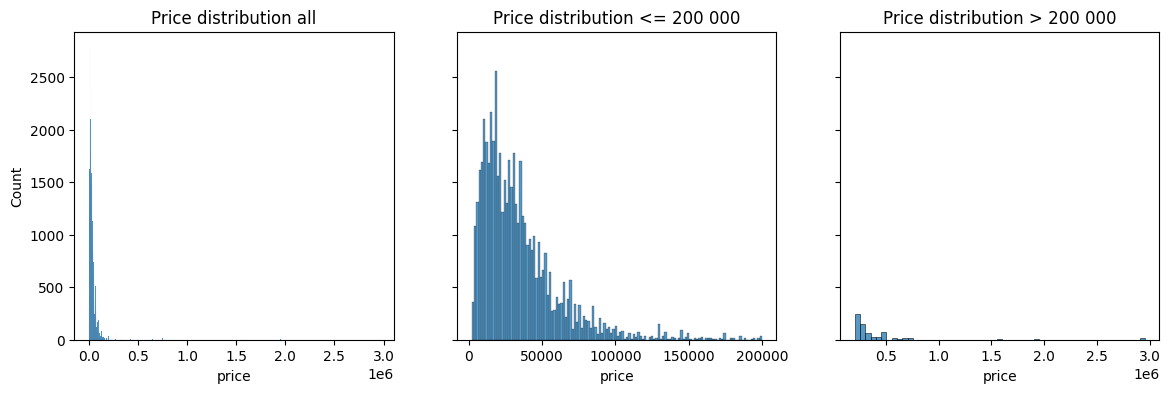

In [332]:
fig, axes = plt.subplots(1,3, figsize = (14,4), sharey = True)

#axes[0].set_ylabel('asdjas')
ax1 = sns.histplot(data = df_train_mod1['price'], ax = axes[0])
ax1.set_title('Price distribution all')
ax2 = sns.histplot(data = df_train_mod1[df_train_mod1['price']<=200000]['price'], ax = axes[1])
ax2.set_title('Price distribution <= 200 000')
ax3 = sns.histplot(data = df_train_mod1[df_train_mod1['price']>200000]['price'], ax = axes[2])
ax3.set_title('Price distribution > 200 000')
plt.show()

<span style="color: gold;">From the above, looking at the graph in the middle,  we see that filtering the data set reduces the noise significantly. We have a better sample of vehicles with a distribution very similar to a normal one, which is ideal. </span> 

In [333]:
df_train_mod1.sort_values(['price'], ascending = False).head(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,price,brand_country,brand_continent,fuel,horsepower,displacement,cylinders,tsm,exterior_color,interior_color
39761,39761,Chevrolet,Suburban 1500 LTZ,2010,194000,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Black,...,2954083,United States,America,Gasoline,355.0,5.3,8.0,Automatic,Other,Black
37341,37341,Porsche,911 Carrera 4S,2005,28500,Gasoline,355.0HP 3.8L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,...,2954083,Germany,Europe,Gasoline,355.0,3.8,6.0,Manual,Other,Black


<span style="color: gold;">The most expensive vehicles seem to be the luxurious one. Excluding this from the model will improve the perfromance </span>

In [334]:
df_train_mod1[df_train_mod1['price']<=200000]['price'].describe()

count     53610.000000
mean      34407.623093
std       27558.700566
min        2000.000000
25%       15500.000000
50%       27800.000000
75%       44850.000000
max      200000.000000
Name: price, dtype: float64

In [335]:
# Therefore we filter our dataset to exclude the noise
df = df_train_mod1[df_train_mod1['price']<=200000].copy().reset_index(drop = True)

* <span style="color: gold;">Model year </span>

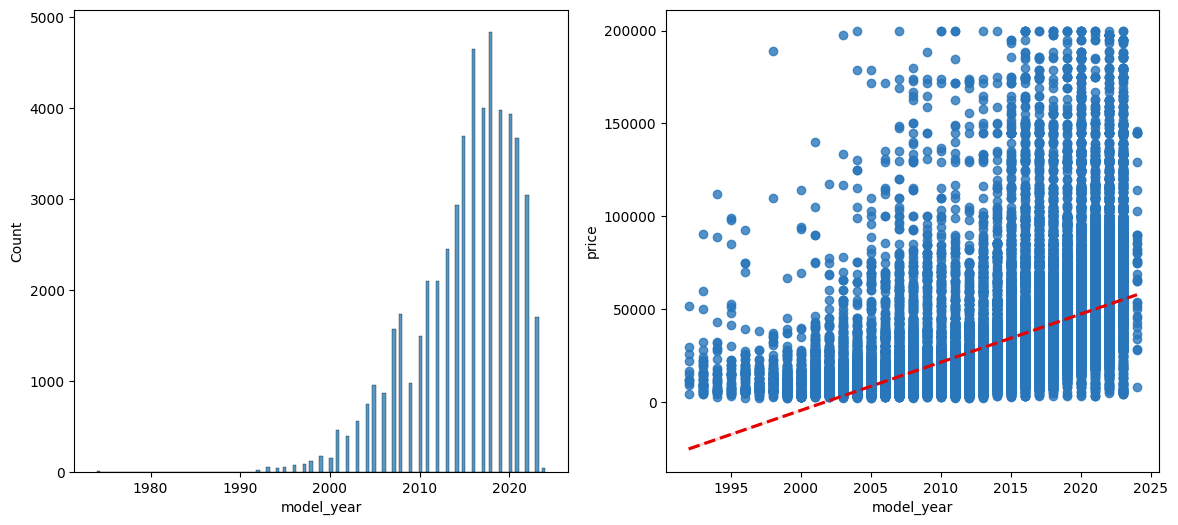

In [336]:
fig, axes = plt.subplots(1,2, figsize = (14,6))

sns.histplot(data = df['model_year'], ax = axes[0])
sns.regplot(data = df[(df['model_year'] >= 1990)], x = 'model_year', y = 'price', color = 'red',
            scatter_kws = {'color': sns.xkcd_rgb['bluish']},
            line_kws = {'color': sns.xkcd_rgb['red'], 'linestyle': '--'}, ax = axes[1])

plt.show()

<span style="color: gold;">A great proportion of cars are relatively new models, the average being the year 2015. We can see a concentration of cars between 2010 and 2020. As a result, we see a positive correlation between model year and price, which is to be expected. </span>

<span style="color: gold;">The same trend is seen for the Milage where vehicles with lower milages are more expensive than those with high milage. </span>

* <span style="color: gold;">Milage </span> 

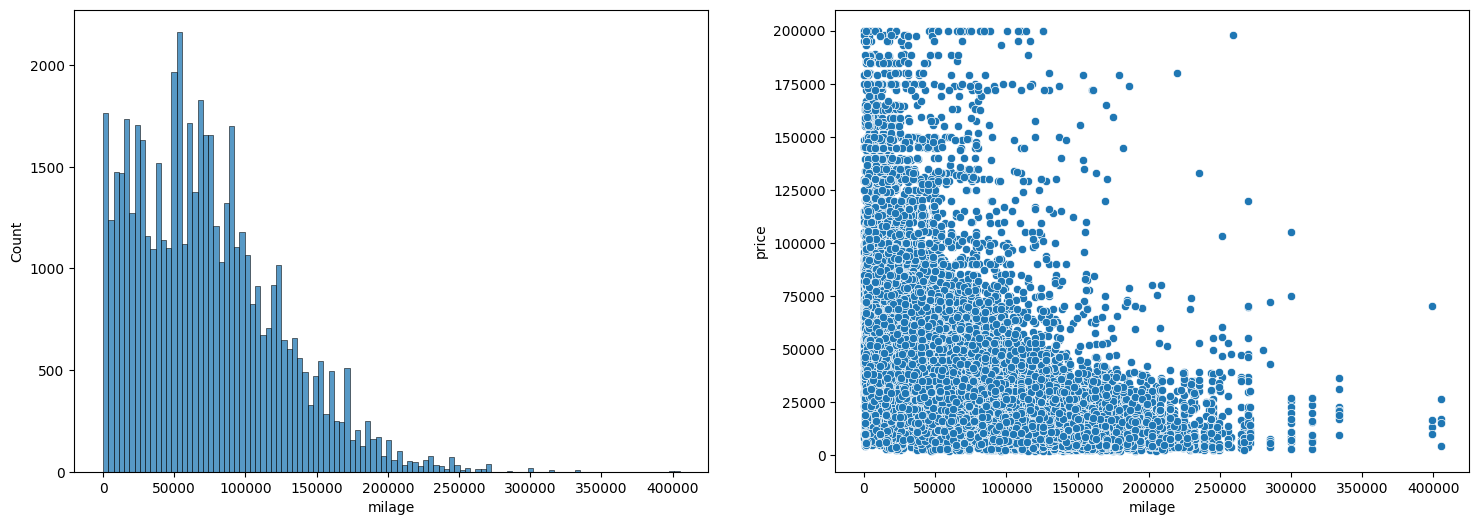

In [337]:
fig, axes = plt.subplots(1,2, figsize = (18,6))

sns.histplot(data = df['milage'], ax = axes[0])
sns.scatterplot(data = df, x = 'milage', y = 'price', ax = axes[1])

plt.show()

* <span style="color: gold;">Horsepower </span> 

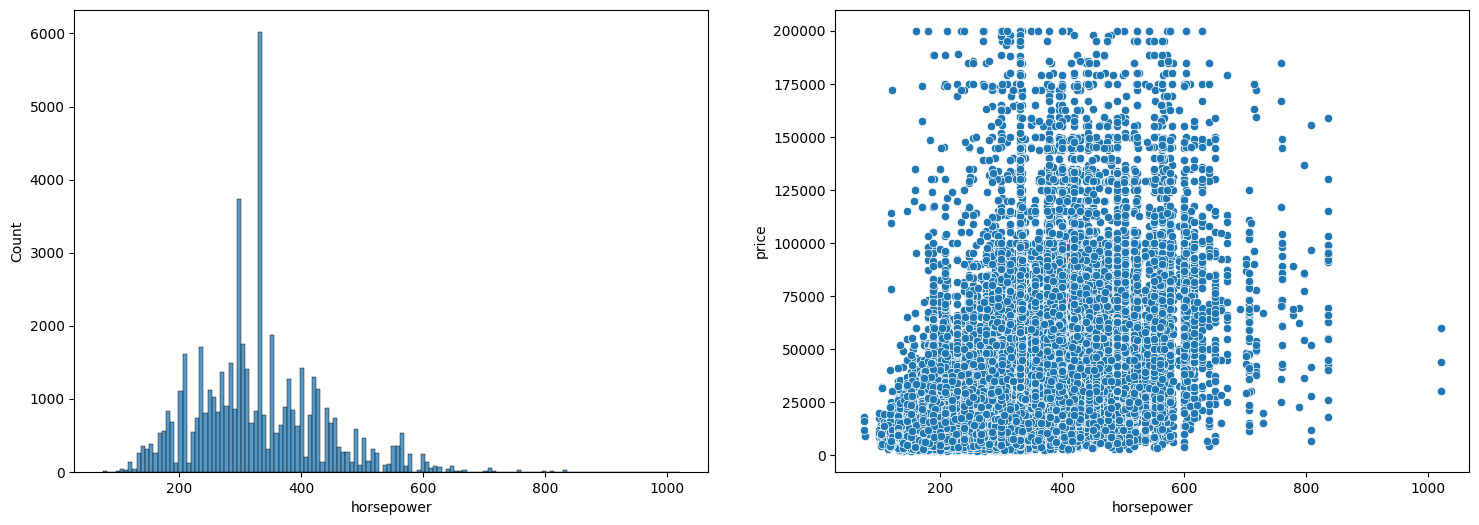

In [286]:
fig, axes = plt.subplots(1,2, figsize = (18,6))

sns.histplot(data = df['horsepower'], ax = axes[0])
sns.scatterplot(data = df, x = 'horsepower', y = 'price', ax = axes[1])

plt.show()

* <span style="color: gold;">Cylinders </span> 

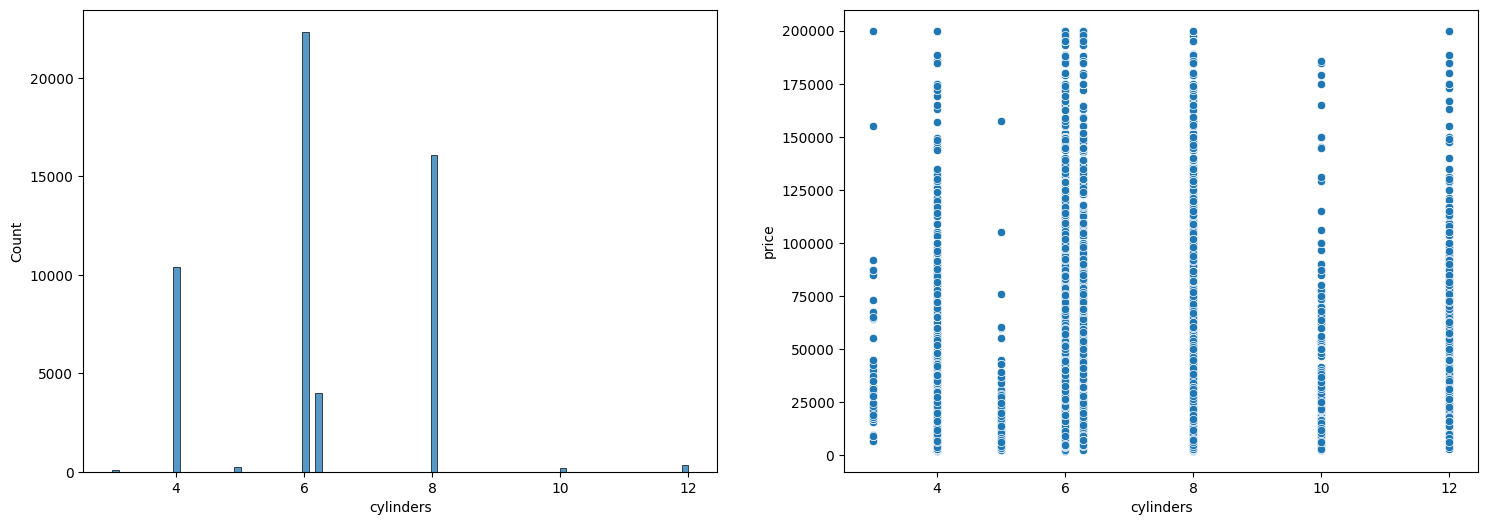

In [287]:
fig, axes = plt.subplots(1,2, figsize = (18,6))

sns.histplot(data = df['cylinders'], ax = axes[0])
sns.scatterplot(data = df, x = 'cylinders', y = 'price', ax = axes[1])

plt.show()

* <span style="color: gold;">Fuel Type </span> 

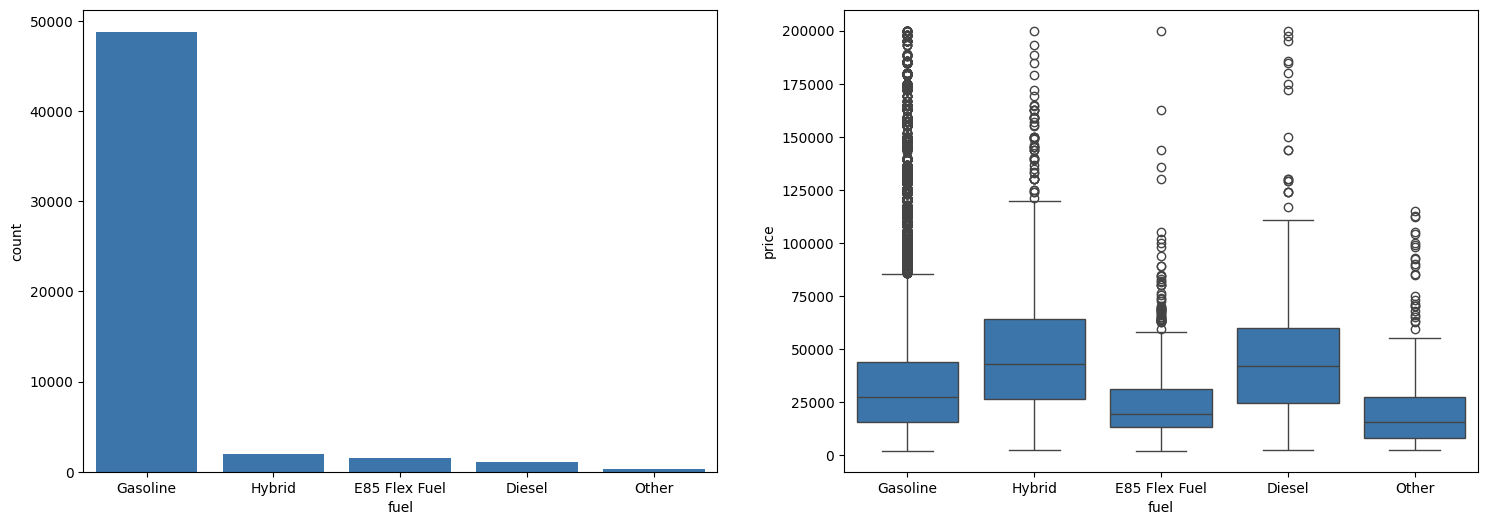

In [47]:
fig, axes = plt.subplots(1,2, figsize = (18,6))

sns.barplot(data = df['fuel'].value_counts().reset_index(), x = 'fuel', y = 'count', color = sns.xkcd_rgb['bluish'], ax = axes[0])
sns.boxplot(data = df, x = 'fuel', y = 'price', color = sns.xkcd_rgb['bluish'], ax = axes[1])

plt.show()

* <span style="color: gold;">Brand Country </span> 

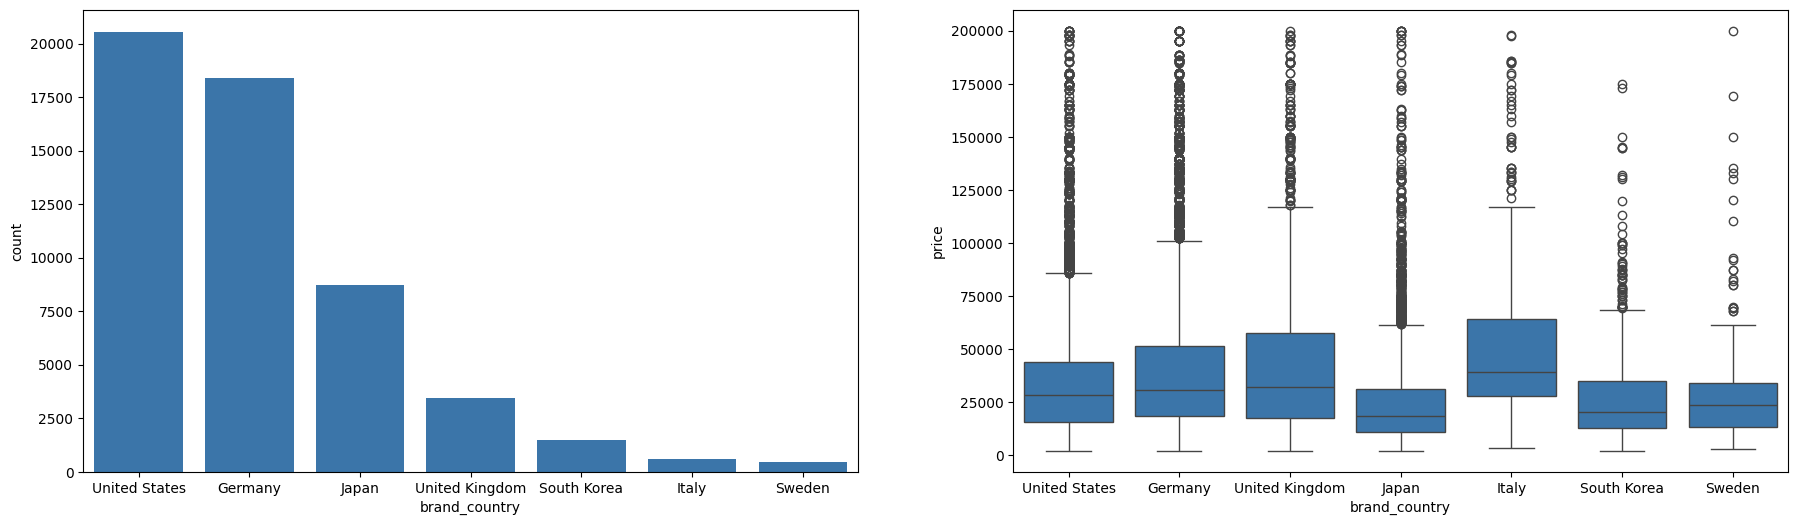

In [290]:
fig, axes = plt.subplots(1,2, figsize = (22,6))

sns.barplot(data = df['brand_country'].value_counts().reset_index(), x = 'brand_country', y = 'count', color = sns.xkcd_rgb['bluish'], ax = axes[0])
sns.boxplot(data = df, x = 'brand_country', y = 'price', color = sns.xkcd_rgb['bluish'], ax = axes[1])

plt.show()

* <span style="color: gold;">Brand Continent </span> 

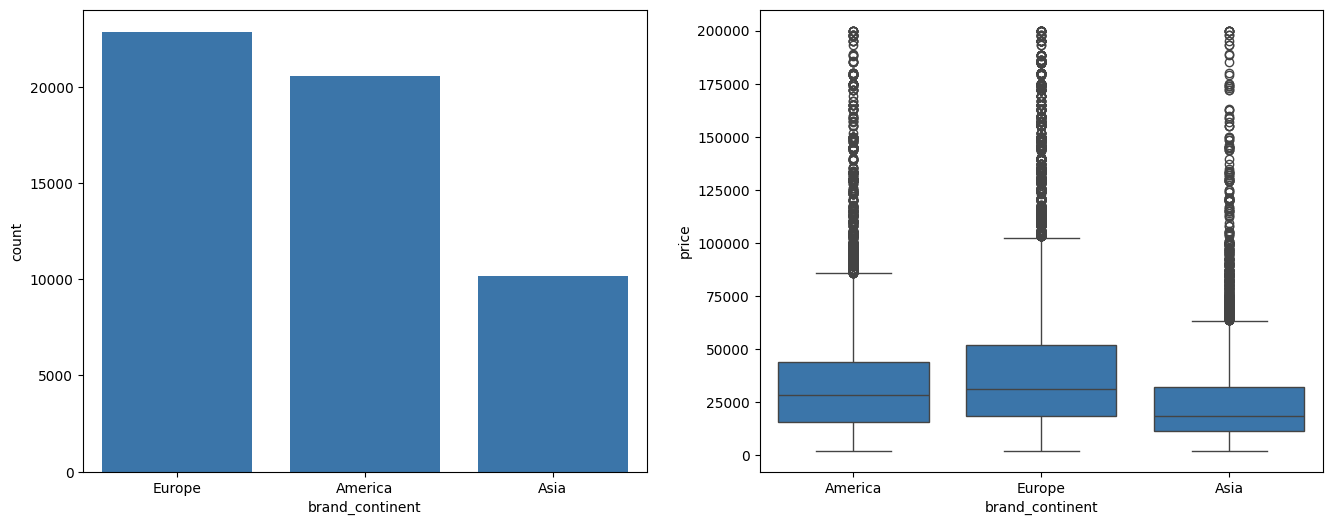

In [291]:
fig, axes = plt.subplots(1,2, figsize = (16,6))

sns.barplot(data = df['brand_continent'].value_counts().reset_index(), x = 'brand_continent', y = 'count', color = sns.xkcd_rgb['bluish'], ax = axes[0])
sns.boxplot(data = df, x = 'brand_continent', y = 'price', color = sns.xkcd_rgb['bluish'], ax = axes[1])

plt.show()

<span style="color: gold;">The average price is 34407 dollars which further proves that a better estimate can be achieved by excluding expensive vehicles. </span>

In [338]:
y = df.price
print('Coefficient of variation of price: ' + str((y.std()/y.mean())))
print('Mean price:' + str(y.describe()['mean']))

Coefficient of variation of price: 0.8009475252488294
Mean price:34407.623092706584


<span style="color: gold;">The three sigma rule provides a quick way to estimate the probability of a data point falling within a certain range around the mean in a normal distribution. This will be crutial to identifying outliers and excluding them. </span> 

In [339]:
print('Three sigma limit: ' + str((y.mean() + y.std()*3)))
print('Percentage of data: ' + str((y[y<=(y.mean() + y.std()*3)].shape[0]/df.shape[0])))

Three sigma limit: 117083.72479010001
Percentage of data: 0.9799664241745943


<span style="color: gold;">We filter the outliers composed of expensive cars through our three sigma limit set at 117083. </span> 

In [340]:
limit = y.mean() + y.std()*3
df_new = df[y<= limit].copy()

In [341]:
df_new.shape, df.shape

((52536, 22), (53610, 22))

* <span style="color: gold;">Mutual Infomation </span> 

In [342]:
X_mi = df_new.copy()
y = X_mi.pop('price')

# Label encoding for discrete features(categorical variables)
for colname in X_mi.select_dtypes('object'):
    X_mi[colname], _ = X_mi[colname].factorize()

# Set set all discrete features to have integer dtypes
discrete_features = X_mi.dtypes == int

# Calculate mi scores
def calc_mi_scores(X_mi, y):
    mi_scores = mutual_info_regression(X_mi, y)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = calc_mi_scores(X_mi, y)

In [343]:
X_mi.isnull().sum()

id                 0
brand              0
model              0
model_year         0
milage             0
fuel_type          0
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
brand_country      0
brand_continent    0
fuel               0
horsepower         0
displacement       0
cylinders          0
tsm                0
exterior_color     0
interior_color     0
dtype: int64

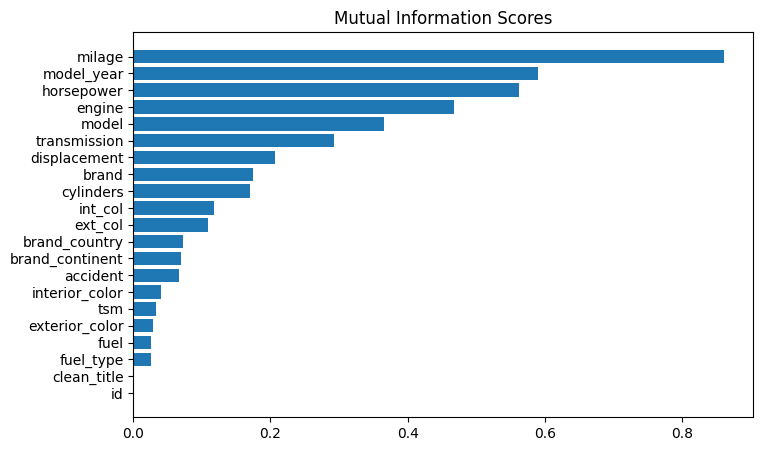

In [344]:
# Plot bar graph for comparisons
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')
    
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

# <span style="color: yellow;">4. Pre-Processing </span> 

In [544]:
# Define predictor variable.
X_tr = X_mi.copy()
features = ['id','model_year','milage','clean_title','horsepower', 'displacement', 'cylinders',
            'accident', 'brand_country', 'brand_continent', 'fuel', 'tsm', 'exterior_color','interior_color']
features1 =['id','model_year','milage','horsepower']
features2 =['id','model_year','milage','horsepower','model', 'transmission']
features3 =['id','model_year','milage','horsepower','displacement'] 
features4 =['id','model_year','milage','horsepower','accident', 'brand_continent'] 
features5 =['id','model_year','milage','horsepower','accident', 'brand_country']
features6 =['id','model_year','milage','horsepower','accident', 'fuel', 'tsm', 'exterior_color','interior_color']


In [545]:
X_tr.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,clean_title,brand_country,brand_continent,fuel,horsepower,displacement,cylinders,tsm,exterior_color,interior_color
0,0,0,0,2018,74349,0,0,0,0,0,...,0,0,0,0,375.0,3.5,6.0,0,0,0
1,1,1,1,2007,80000,0,1,1,1,1,...,0,1,1,0,300.0,3.0,6.0,1,1,1
2,2,2,2,2009,91491,0,2,2,2,2,...,0,2,1,0,300.0,4.2,8.0,0,0,0
3,3,1,3,2022,2437,1,3,3,3,3,...,0,1,1,1,335.0,3.0,6.0,2,0,0
4,4,3,4,2001,111000,0,4,4,4,1,...,0,0,0,0,200.0,3.8,6.0,0,2,1


* <span style="color: gold;">Scaling </span>  

* <span style="color: gold;">We apply a standard scaler for the values of these columns, mainly because the size of the milage values could generate a bit of noise and because we want a balanced dataset. </span>  

In [546]:
X_test = df_test_mod1[features2].copy()
# Label encoding for discrete features(categorical variables)
for colname in X_test.select_dtypes('object'):
    X_test[colname], _ = X_test[colname].factorize()
X_test.head()

,id,model_year,milage,horsepower,model,transmission
0,54273,2014,73000,302.0,0,0
1,54274,2015,128032,275.0,1,1
2,54275,2015,51983,241.0,2,2
3,54276,2018,29500,518.0,3,3
4,54277,2020,90000,335.0,4,1


<span style="color: gold;">Adjust features here </span>

In [559]:
X_t = X_tr[features2]

In [560]:
scaler = StandardScaler()
numeric_columns = features1
# indexes = X_tr.index.tolist()
# X_id = X_test['id']
X_t[numeric_columns] = scaler.fit_transform(X_t[numeric_columns])
# X_train_num = pd.DataFrame(scaler.fit_transform(X_tr[numeric_columns]), index = indexes, columns = numeric_columns)
# X_test_num = pd.DataFrame(scaler.fit_transform(X_test.pop('id')), index = indexes, columns = numeric_columns)

# Combine the scaled features
# X_t = pd.concat([X_train_num], axis = 1)
# X_test = pd.concat([X_id, X_test_num], axis = 1)


/var/folders/rc/s98tj6kj6q73kgjcxg9rnmdm0000gn/T/ipykernel_84019/3265830397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_t[numeric_columns] = scaler.fit_transform(X_t[numeric_columns])


In [561]:
X_t.head()

,id,model_year,milage,horsepower,model,transmission
0,-1.732754,0.543257,0.003687,0.453950,0,0
1,-1.732690,-1.428234,0.116199,-0.280309,1,1
2,-1.732626,-1.069781,0.344988,-0.280309,2,2
3,-1.732562,1.260163,-1.428096,0.062345,3,3
4,-1.732499,-2.503593,0.733416,-1.259320,4,4


In [549]:
X_t.shape, y.shape

((52536, 6), (52536,))

In [533]:
print(X_t.dtypes)
print('-'*20)
# print(X_test.dtypes)

id                int64
model_year        int64
milage            int64
horsepower      float64
displacement    float64
dtype: object
--------------------


# <span style="color: yellow;">5. Train the Model </span> 
<span style="color: gold;">We will try first with some baseline models like linear and polynomial regression, to see if we can have good results based on the insights we saw on the corresponding EDA. </span> 

* <span style="color: gold;">Training Function </span> 

In [562]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y, test_size=0.2, random_state=42)

In [563]:
def eval_metrics(regressor):
    y_pred = regressor.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    score = r2_score(y_val, y_pred)
    
    print('Evaluation set metrics')
    print('-'*10)
    print('R-squared: ' + str(score))
    print('RMSE: ' + str(rmse))
    print('MAE: ' + str(mae))
    

* <span style="color: gold;">Linear Regression </span>

In [564]:
Lr = LinearRegression()
Lr.fit(X_train, y_train)

LinearRegression()

In [565]:
eval_metrics(Lr)

Evaluation set metrics
----------
R-squared: 0.5329468760545408
RMSE: 15153.327443100567
MAE: 10893.645046596801


* <span style="color: gold;">Decision Trees</span>


In [454]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [455]:
eval_metrics(tree)

Evaluation set metrics
----------
R-squared: 0.5843720192122059
RMSE: 14294.772759766476
MAE: 9933.018743951601


* <span style="color: gold;">Random Forest</span>

In [566]:
forest = RandomForestRegressor(max_depth=5, n_jobs= -1)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_jobs=-1)

In [567]:
eval_metrics(forest)

Evaluation set metrics
----------
R-squared: 0.5969223541029461
RMSE: 14077.295398669998
MAE: 9753.922837296948


* <span style="color: gold;">xgboost</span>

In [568]:
xgb = XGBRegressor(learning_rate=0.1, n_estimators=1000)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [569]:
eval_metrics(xgb)

Evaluation set metrics
----------
R-squared: 0.610053699656245
RMSE: 13846.093798863292
MAE: 9333.565203558868


<span style="color: gold;">Round 1: using features, xgboost takes the first round, edging random forest by 1%  </span>

<span style="color: gold;">Round 2: using features1, xgboost takes the second round, slightly edging random forest, but notice that the scores were lower.   </span>

<span style="color: gold;">Round 3: using features2, xgboost takes the third round, with a score of 61%. </span>

<span style="color: gold;">After running through all the rounds features and features2 seem to produce better results. </span>

# <span style="color: yellow;">6. Grid Search </span> 

* <span style="color: orange;">We will fine tune the hyperparameters to find the model that performs better </span>

* <span style="color: orange;">Random Forest </span> 

In [570]:
%%time

param_grid = {'n_estimators': [5,10,100,500], 'max_features': [2,4,6,'auto'], 'max_depth': [4,8,12]}

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose = 10, n_jobs = -1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

forest = RandomForestRegressor(max_depth = 12, max_features = 2, n_estimators = 500, n_jobs = -1)
forest.fit(X_train, y_train)

eval_metrics(forest)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START max_depth=4, max_features=2, n_estimators=5................
[CV 2/5; 1/48] START max_depth=4, max_features=2, n_estimators=5................
[CV 3/5; 1/48] START max_depth=4, max_features=2, n_estimators=5................
[CV 5/5; 1/48] START max_depth=4, max_features=2, n_estimators=5................
[CV 4/5; 1/48] START max_depth=4, max_features=2, n_estimators=5................
[CV 1/5; 1/48] END max_depth=4, max_features=2, n_estimators=5;, score=(train=-208264378.480, test=-209340262.536) total time=   0.1s
[CV 2/5; 1/48] END max_depth=4, max_features=2, n_estimators=5;, score=(train=-208598162.247, test=-204529638.189) total time=   0.1s
[CV 3/5; 1/48] END max_depth=4, max_features=2, n_estimators=5;, score=(train=-212675970.759, test=-213077211.941) total time=   0.1s
[CV 4/5; 2/48] START max_depth=4, max_features=2, n_estimators=10...............
[CV 5/5; 1/48] END max_depth=4, max_features=2, n_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

{'max_depth': 12, 'max_features': 2, 'n_estimators': 500}
Evaluation set metrics
----------
R-squared: 0.6269409774157632
RMSE: 13542.961418717921
MAE: 9212.055250081785
CPU times: user 34.4 s, sys: 1.17 s, total: 35.6 s
Wall time: 3min 38s


##### - xgboost

In [571]:
%%time

param_grid = {'learning_rate': [0.1, 0.3, 0.5],                
              'max_depth': [5,10,15],
              'n_estimators': [300,700,1000]}

xgb = XGBRegressor()

grid_search = GridSearchCV(xgb, param_grid,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose = False, n_jobs = -1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

xgb = XGBRegressor(learning_rate = 0.5, max_depth = 15, n_estimators = 100, n_jobs = -1)
xgb.fit(X_train, y_train)

eval_metrics(xgb)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Evaluation set metrics
----------
R-squared: 0.5133378962919255
RMSE: 15468.15914861001
MAE: 10520.810470148326
CPU times: user 8.51 s, sys: 4.53 s, total: 13 s
Wall time: 3min 57s


# 7. Results

In [ ]:
# Convert to a dataframe and set it up in the required format
y_pred = pd.DataFrame(np.around(y_hat)).astype(int)
y_pred.columns = ['Price']
y_pred = pd.concat([X_test[['id']], y_pred[['Price']]], axis=1)
y_pred.head(10)

In [36]:
#  Export data 
y_pred_Linr.to_csv('/Users/charityvetezo/Desktop/Data Sciences/Kaggle/Skills Assessment/Prediction_19_lr.csv', index=False)